In [1]:
from __future__ import print_function

import sys
import pyodbc
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math

from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#!pip install ipython-autotime
#%load_ext autotime

In [2]:
import os
os.chdir('./ExoticPinger/Jupyter/PuntingPro')
os.getcwd()

'C:\\Users\\nick\\source\\repos\\ExoticPinger\\Jupyter\\PuntingPro'

In [3]:
rawData = pd.read_csv('PP.csv')
rawData['DATE'] = pd.to_datetime(rawData['DATE'], format="%d-%b-%y")
rawData.head(25)

,DATE,TIME,VENUE,RACE,SELECTION,JOCKEY,LAST 3 STARTS,RESULT,WIN/PLACE
0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
clean = rawData[rawData['DATE'].notna()]
clean = clean[clean.SELECTION.notna()]
clean.head()

,DATE,TIME,VENUE,RACE,SELECTION,JOCKEY,LAST 3 STARTS,RESULT,WIN/PLACE
22,2020-10-22,13:25,HAWKESBURY,1,7 – LET ME THINK,R.BAYLISS,334,WINNER,$2.28 /$1.17
23,2020-10-22,13:30,BALLARAT,2,1 - AMERICAIN ANGEL (BEST BET),D.MOOR,2,2ND,/$1.99
24,2020-10-22,14:05,HAWKESBURY,2,1 – SHADOW COLOUR,T.SCHILLER(A),222,2ND,/$1.38
25,2020-10-22,14:20,ROCKHAMPTON,1,4 – ROCKN BLITZ,R.STEWART,432,NaN,NaN
26,2020-10-22,14:30,BALLARAT,4,3 – DON’T QUESTION ME,M.POY(A),37X,WINNER,$5.00 /$1.88


In [5]:
clean['BestBet'] =  clean['SELECTION'].str.contains("(BEST BET)")
clean["WIN/PLACE"] = clean["WIN/PLACE"].str.replace(' ', '')
clean.drop(clean[clean["WIN/PLACE"] == "SCRATCHING"].index, inplace=True)
clean.drop(clean[clean["WIN/PLACE"] == "ABANDONED"].index, inplace=True)
clean.drop(clean[clean["WIN/PLACE"] == "BET"].index, inplace=True)
new = clean["WIN/PLACE"].str.split("/", n = 1, expand = True) 
clean['WinPrice'] =  new[0].apply(lambda x: 0 if x == '' else x).str.replace('$', '').fillna(0).astype(float)
clean['PlacePrice'] =  new[1].fillna(0).apply(lambda x: 0 if x == '' else x).str.replace('$', '').fillna(0).astype(float)
clean['DayOfWeek'] = clean['DATE'].dt.day_name()
clean.sort_values(by=['DATE'], inplace=True)
clean.reset_index(drop=True, inplace=True)
clean.head(10)

C:\Users\nick\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,DATE,TIME,VENUE,RACE,SELECTION,JOCKEY,LAST 3 STARTS,RESULT,WIN/PLACE,BestBet,WinPrice,PlacePrice,DayOfWeek
0,2020-06-30,14:04,BUNDABURG,2,2 – NICCO’S LASS,P.HAMBLIN,421,2ND,/$1.91,False,0.00,1.91,Tuesday
1,2020-06-30,11:50,MACKAY,1,1 – ASPEN LAD,W.D'AVILA,X11,WINNER,$1.47/$1.16,False,1.47,1.16,Tuesday
2,2020-06-30,12:10,GOSFORD,1,1 – PRINCE SIX,K.JENNINGS,752,NaN,NaN,False,0.00,0.00,Tuesday
3,2020-06-30,12:30,BALLARAT,1,2 – CATADUDE,D.STACKHOUSE,2X2,WINNER,$1.77/$1.20,False,1.77,1.20,Tuesday
4,2020-06-30,13:55,GOSFORD,4,4 – JAZIRAT,A.HYERONIMUS,852,NaN,NaN,False,0.00,0.00,Tuesday
5,2020-06-30,13:05,MACKAY,3,2 – SHE’S OUR RIPPA (BEST BET),A.BUTLER,313,NaN,NaN,True,0.00,0.00,Tuesday
6,2020-06-30,13:20,GOSFORD,3,2 – CAMERLENGO,T.CLARK,2,3RD,/$1.18,False,0.00,1.18,Tuesday
7,2020-06-30,13:40,MACKAY,4,1 – ALL STAR ROCKET,A.SEWELL,221,2ND,/$1.50,False,0.00,1.50,Tuesday
8,2020-06-30,13:00,BALLARAT,2,9 - IMPETUS,D.STACKHOUSE,2,WINNER,$3.75/$1.26,False,3.75,1.26,Tuesday
9,2020-07-01,13:00,SANDOWN,2,3 – NOT A ZAK,C.WILLIAMS,X23,3RD,/$1.62,False,0.00,1.62,Wednesday


In [6]:
clean.tail(10)

,DATE,TIME,VENUE,RACE,SELECTION,JOCKEY,LAST 3 STARTS,RESULT,WIN/PLACE,BestBet,WinPrice,PlacePrice,DayOfWeek
2110,2020-10-22,16:45,ROCKHAMPTON,5,6 – ARTEMIS GIRL,B-D.APPO,53,NaN,NaN,False,0.00,0.00,Thursday
2111,2020-10-22,16:00,BALLARAT,7,2 – MISS HELLBENDER,M.LLOYD(A),6X1,NaN,NaN,False,0.00,0.00,Thursday
2112,2020-10-22,16:34,GERALTON,1,7 – WEDNESDAY,S.PARNHAM,324,WINNER,$2.58/$1.30,False,2.58,1.30,Thursday
2113,2020-10-22,17:05,HAWKESBURY,7,3 – ELECTRIFIED,B.AVDULLA,X62,2ND,/$1.30,False,0.00,1.30,Thursday
2114,2020-10-22,17:12,GERALTON,2,9 – BUSH ICON,K.YUILL,522,WINNER,$2.60/$1.40,False,2.60,1.40,Thursday
2115,2020-10-22,17:25,ROCKHAMPTON,6,2 – BOGEY MAN,R.WIGGINS,106,NaN,NaN,False,0.00,0.00,Thursday
2116,2020-10-22,17:40,HAWKESBURY,8,1 – MALKOVICH (BEST BET),R.KING,312,WINNER,$1.59/$1.10,True,1.59,1.10,Thursday
2117,2020-10-22,17:47,GERALTON,3,4 – INVICTUS DOMINI,M.PATEMAN,2X1,WINNER,$1.37/$1.04,False,1.37,1.04,Thursday
2118,2020-10-22,15:35,ROCKHAMPTON,3,6 – HOLY FREEZE,J.STANLEY,X21,WINNER,$1.80/$1.10,False,1.80,1.10,Thursday
2119,2020-10-22,13:25,HAWKESBURY,1,7 – LET ME THINK,R.BAYLISS,334,WINNER,$2.28/$1.17,False,2.28,1.17,Thursday


In [7]:
def GetResults(stopLoss, profitTarget, takeShortBetsWinOnly = False):
    results = pd.DataFrame(columns=['Date', 'PL'])
    resultsCnt = 1

    dateOfLastTip = clean.head(1).DATE[0]
    dailyPL = 0
    placeBet = 450
    winBet = 50
    dayProfitAchieved = False

    for index, row in clean.iterrows():
        dateOfThisTip = row.DATE
        if (dateOfThisTip != dateOfLastTip): #new day
            dateOfLastTip = dateOfThisTip
            if dayProfitAchieved == False:
                #print('New day: {}'.format(dateOfLastTip))
                results = results.append ({'Date': dateOfLastTip, 'PL': dailyPL}, ignore_index=True)
            else:
                placeBet = 450
                winBet = 50
                
            dailyPL = 0
            
            dayProfitAchieved = False
        if dayProfitAchieved == False:
            if takeShortBetsWinOnly and row.WinPrice <= 3:
                betSize = winBet + placeBet
                betRes = row.WinPrice * betSize - betSize
            else:
                winRes = row.WinPrice * winBet - winBet
                placeRes = row.PlacePrice * placeBet - placeBet
                betRes = winRes + placeRes
            dailyPL += betRes
            placeBet += 90
            winBet += 10
            if (dailyPL > profitTarget) or (dailyPL < stopLoss):
                dayProfitAchieved = True
                #print('ProfitAchieved: {}'.format(dateOfLastTip))
                results = results.append ({'Date': dateOfLastTip, 'PL': dailyPL}, ignore_index=True)
    return results

GetResults(-1000, 400).PL.sum()

2653.7

In [8]:
GetResults(-1000, 400).PL.sum()

2653.7

In [9]:
profits = [100, 150, 200, 250, 300, 400]
stopLosses = [-1000, -1500, -2000, -2500, -3000, -4000, -5000, -7500, -10000]
resultSum = pd.DataFrame(columns=['ProfitTarget', 'StopLoss', 'TotalReturn'])

for profit in profits:
    for sl in stopLosses:
        resultSum = resultSum.append ({'ProfitTarget': profit, 'StopLoss': sl, 'TotalReturn': GetResults(sl, profit).PL.sum()}, ignore_index=True)
        
resultSum['Positive'] = resultSum['TotalReturn'] > 0

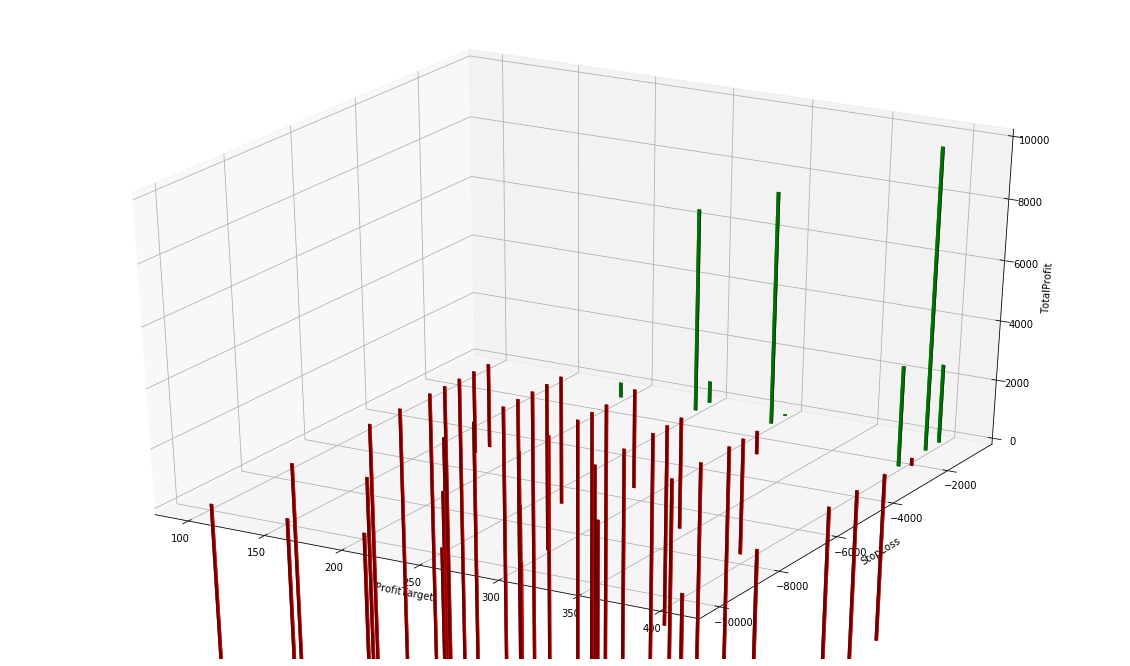

In [10]:
#%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(111, projection='3d')

xpos = resultSum.ProfitTarget.array
ypos = resultSum.StopLoss.array
num_elements = len(xpos)
len1 = len(resultSum.index)
zpos = np.zeros(len1)
dx = np.ones(len1)*2
dy = np.ones(len1)*20
dz = resultSum.TotalReturn.array


ax1.set_xlabel('ProfitTarget')
ax1.set_ylabel('StopLoss')
ax1.set_zlabel('TotalProfit')

ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, color=resultSum.Positive.map({True: 'g', False: 'r'}))
plt.show()

In [11]:
betSize = 1000
clean['WinReturn'] = betSize * clean.WinPrice - betSize
clean['PlaceReturn'] = betSize * clean.PlacePrice - betSize

In [12]:
clean['WinReturn'].sum()

-139510.0

In [13]:
clean['PlaceReturn'].sum()

-88790.0

In [14]:
clean.head()

,DATE,TIME,VENUE,RACE,SELECTION,JOCKEY,LAST 3 STARTS,RESULT,WIN/PLACE,BestBet,WinPrice,PlacePrice,DayOfWeek,WinReturn,PlaceReturn
0,2020-06-30,14:04,BUNDABURG,2,2 – NICCO’S LASS,P.HAMBLIN,421,2ND,/$1.91,False,0.00,1.91,Tuesday,-1000.0,910.0
1,2020-06-30,11:50,MACKAY,1,1 – ASPEN LAD,W.D'AVILA,X11,WINNER,$1.47/$1.16,False,1.47,1.16,Tuesday,470.0,160.0
2,2020-06-30,12:10,GOSFORD,1,1 – PRINCE SIX,K.JENNINGS,752,NaN,NaN,False,0.00,0.00,Tuesday,-1000.0,-1000.0
3,2020-06-30,12:30,BALLARAT,1,2 – CATADUDE,D.STACKHOUSE,2X2,WINNER,$1.77/$1.20,False,1.77,1.20,Tuesday,770.0,200.0
4,2020-06-30,13:55,GOSFORD,4,4 – JAZIRAT,A.HYERONIMUS,852,NaN,NaN,False,0.00,0.00,Tuesday,-1000.0,-1000.0


In [15]:
clean[clean.BestBet]['WinReturn'].sum()

-10450.0

In [22]:
clean[clean.BestBet]['PlaceReturn'].sum()

13990.0

In [17]:
groupedDow = clean[clean.BestBet].groupby('DayOfWeek').agg({'WinReturn': 'sum', 'PlaceReturn': 'sum'})
groupedDow

,WinReturn,PlaceReturn
DayOfWeek,,
Friday,-8460.0,3170.0
Monday,4760.0,4430.0
Saturday,-10230.0,620.0
Sunday,6130.0,4750.0
Thursday,4970.0,3060.0
Tuesday,-3400.0,-2000.0
Wednesday,-4220.0,-40.0


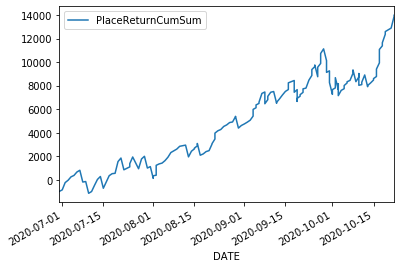

In [18]:
bestBets = clean[clean.BestBet].copy()
bestBets['PlaceReturnCumSum'] = bestBets['PlaceReturn'].cumsum()
bestBets.plot(kind='line', x= 'DATE', y='PlaceReturnCumSum')

In [19]:
bestBets.tail(10)

,DATE,TIME,VENUE,RACE,SELECTION,JOCKEY,LAST 3 STARTS,RESULT,WIN/PLACE,BestBet,WinPrice,PlacePrice,DayOfWeek,WinReturn,PlaceReturn,PlaceReturnCumSum
2001,2020-10-16,14:35,MURRAY BRIDGE,3,6 – MR POCKET (BEST BET),T.PANNELL,X43,2ND,/$1.63,True,0.00,1.63,Friday,-1000.0,630.0,9410.0
2021,2020-10-17,14:58,DOOMBEN,4,1 – FASNET CYCLONE (BEST BET),B.NOTHDURFT,113,3RD,/$1.53,True,0.00,1.53,Saturday,-1000.0,530.0,9940.0
2028,2020-10-17,13:25,CAULFIELD,3,2 – OSAMU (BEST BET),D.LANE,244,2ND,/$2.14,True,0.00,2.14,Saturday,-1000.0,1140.0,11080.0
2055,2020-10-18,13:05,SUNSHINE COAST,1,2 – MONSTER OF POWER (BEST BET),L.CASSIDY,X35,3RD,/$1.31,True,0.00,1.31,Sunday,-1000.0,310.0,11390.0
2074,2020-10-18,18:00,SUNSHINE COAST,9,1 – ALL TO DO (BEST BET),J.ORMAN,X22,2ND,/$1.26,True,0.00,1.26,Sunday,-1000.0,260.0,11650.0
2081,2020-10-19,15:05,MUSWELLBROOK,4,13 – LIONSTEPS (BEST BET),G.RYAN,233,3RD,/$1.72,True,0.00,1.72,Monday,-1000.0,720.0,12370.0
2086,2020-10-19,17:00,MORNINGTON,9,12 – PRIDE OF JENNI (BEST BET),J.KAH,331,WINNER,$2.08/$1.23,True,2.08,1.23,Monday,1080.0,230.0,12600.0
2095,2020-10-21,16:20,NARACOORTE,6,3 – THE RAVEN (BEST BET),M.COLLETT(A),446,WINNER,$2.10/$1.30,True,2.10,1.30,Wednesday,1100.0,300.0,12900.0
2103,2020-10-22,13:30,BALLARAT,2,1 - AMERICAIN ANGEL (BEST BET),D.MOOR,2,2ND,/$1.99,True,0.00,1.99,Thursday,-1000.0,990.0,13890.0
2116,2020-10-22,17:40,HAWKESBURY,8,1 – MALKOVICH (BEST BET),R.KING,312,WINNER,$1.59/$1.10,True,1.59,1.10,Thursday,590.0,100.0,13990.0


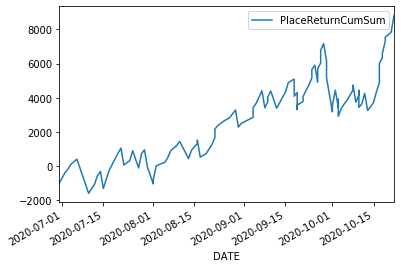

In [20]:
bestBetsPlaceAbove120 = bestBets[(bestBets.PlacePrice >= 1.2) | (bestBets.RESULT.isna())].copy()
bestBetsPlaceAbove120['PlaceReturnCumSum'] = bestBetsPlaceAbove120['PlaceReturn'].cumsum()
bestBetsPlaceAbove120.plot(kind='line', x= 'DATE', y='PlaceReturnCumSum')

In [21]:
bestBetsPlaceAbove120.tail(5)

,DATE,TIME,VENUE,RACE,SELECTION,JOCKEY,LAST 3 STARTS,RESULT,WIN/PLACE,BestBet,WinPrice,PlacePrice,DayOfWeek,WinReturn,PlaceReturn,PlaceReturnCumSum
2074,2020-10-18,18:00,SUNSHINE COAST,9,1 – ALL TO DO (BEST BET),J.ORMAN,X22,2ND,/$1.26,True,0.00,1.26,Sunday,-1000.0,260.0,6590.0
2081,2020-10-19,15:05,MUSWELLBROOK,4,13 – LIONSTEPS (BEST BET),G.RYAN,233,3RD,/$1.72,True,0.00,1.72,Monday,-1000.0,720.0,7310.0
2086,2020-10-19,17:00,MORNINGTON,9,12 – PRIDE OF JENNI (BEST BET),J.KAH,331,WINNER,$2.08/$1.23,True,2.08,1.23,Monday,1080.0,230.0,7540.0
2095,2020-10-21,16:20,NARACOORTE,6,3 – THE RAVEN (BEST BET),M.COLLETT(A),446,WINNER,$2.10/$1.30,True,2.10,1.30,Wednesday,1100.0,300.0,7840.0
2103,2020-10-22,13:30,BALLARAT,2,1 - AMERICAIN ANGEL (BEST BET),D.MOOR,2,2ND,/$1.99,True,0.00,1.99,Thursday,-1000.0,990.0,8830.0
